# 离散值决策树
#####  数据集 Post-Operative from KEEL-dataset - 
##### https://sci2s.ugr.es/keel/dataset.php?cod=179
#### 数据集任务描述：使用8个特征值描述患者在手术后的恢复情况，判断其下一步应当送往哪个恢复区
***
***
    #attribute L-CORE{mid,high,low}  病人内部体温    -中 -高 -低
    #attribute L-SURF{low,high,mid}  病人外部体温    -中 -高 -低 
    #attribute L-O2{excellent,good}  病人氧饱和度    -优 -良    
    #attribute L-BP{mid,high,low}    病人最后血压    -中 -高 -低 
    #attribute CORE-STBL
    {stable,unstable,mod-stable}     体内温度稳定性   -稳定 -半稳定 -不稳定 
    #attribute SURF-STBL
    {stable,unstable}                体表温度稳定性   -稳定 -不稳定
    #attribute BP-STBL
    {stable,mod-stable,unstable}      血压稳定性     -稳定 -半稳定 -不稳定
    #attribute COMFORT{15,10,05,07}   病人舒适程度    -15 -10  -05  -07
    
    #output Decision{I,S,A}           -I重症监护室  -S回家    -A一般楼层病院  
***
***
### 训练集 78条  测试集 9条

In [8]:
###
#从TXT中读取数据创建数据集
###
def createDataSet(filename):
    f = open(filename)
    lines = f.readlines()
    f.close()
    dataSet = []
    for line in lines:
        data = []
        line = line.strip('\n')
        data = line.split(', ')
        dataSet.append(data)
    return dataSet


In [9]:
filename = "C:/Users/charo/Desktop/post-operative-10-1tra.txt"
dataSet = createDataSet(filename)

In [10]:
from math import *

#获取第i特征的各个种类的个数
def countFeatClass(dataSet,i):
    rtnCounts = {}
    for data in dataSet:
        currentValue= data[i]                    #取得当前数据第i特征的value
        if currentValue not in rtnCounts.keys(): #该特征出现一个新的值
            rtnCounts[currentValue] = 0     
        rtnCounts[currentValue] += 1             #当前value对应的data数目+1
    return rtnCounts

#计算香农熵 
def calcEnt(dataSet):
    numData = len(dataSet)
    labelCounts = countFeatClass(dataSet,-1)      #即统计各类结果的个数
    Ent = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numData #每类所占的比例
        Ent -= prob*log(prob,2)                  #根据公式计算熵
    return Ent

#根据第i个特征的各特征值分化数据集
def splitDataSet(dataSet,i,value):
    rtnSet = []
    for data in dataSet:
        if data[i] == value:
            rtnSet.append(data)
    return rtnSet

#获取在当前结点分化第i特征后的信息增益
def getGain(dataSet,i):
    S = calcEnt(dataSet)                        #父节点的香农熵
    labelCounts = countFeatClass(dataSet,i)
    sumOfKidsEnt = 0.0                      
    for key in labelCounts:
        EntOfKid = calcEnt(splitDataSet(dataSet,i,key)) #子节点一个分支的Ent
        p = float(labelCounts[key])/len(dataSet)        #当前分化所占权重比例
        sumOfKidsEnt += p*EntOfKid                  #累加计算子节点总Ent
    return S - sumOfKidsEnt                    #返回增益
        

In [11]:
def buildTree(dataSet,kidTree):
    i = 0
    rtn = kidTree
    tempGain = []                               #暂时存储各种分化情况的Gain
    while i<8:
        tempGain.append(getGain(dataSet,i))
        i += 1
    attr = tempGain.index(max(tempGain))
    labelCounts = countFeatClass(dataSet,attr)
    if(tempGain[attr]) == 0:                    #Gain为0建树完成，返回分类作为叶子
            rtn = dataSet[0][-1]
            return rtn
        
    labels = ["L-CORE", "L-SURF", "L-O2","L-BP","SURF-STBL","CORE-STBL","BP-STBL","COMFORT"]
    label = labels[attr]
   
   
    rtn[label] = {}
    for key in labelCounts:
        kidDataSet =  splitDataSet(dataSet,attr,key)     #分化下一子树的数据集
        rtn[label][key] = buildTree(kidDataSet,{})       #递归建子树
    return rtn                                 #返回本结点的子树


In [12]:
tree = buildTree(dataSet,{})
print(tree)

{'COMFORT': {'15': {'BP-STBL': {'stable': {'L-BP': {'mid': {'L-SURF': {'low': 'A', 'high': 'A', 'mid': {'L-CORE': {'low': 'S', 'mid': {'SURF-STBL': {'unstable': {'L-O2': {'good': 'A', 'excellent': 'S'}}, 'stable': 'A'}}}}}}, 'high': 'S'}}, 'mod-stable': 'A', 'unstable': {'L-SURF': {'low': 'S', 'high': 'A', 'mid': 'A'}}}}, '10': {'L-SURF': {'high': {'SURF-STBL': {'stable': {'BP-STBL': {'stable': 'S', 'mod-stable': 'A'}}, 'unstable': 'A'}}, 'low': {'BP-STBL': {'mod-stable': {'L-BP': {'high': 'A', 'mid': 'S'}}, 'stable': 'A', 'unstable': {'SURF-STBL': {'unstable': {'L-CORE': {'low': 'A', 'mid': 'A'}}, 'stable': 'I'}}}}, 'mid': {'L-BP': {'high': {'BP-STBL': {'stable': {'L-O2': {'excellent': 'A', 'good': {'SURF-STBL': {'unstable': 'A', 'stable': 'S'}}}}, 'unstable': 'S', 'mod-stable': 'A'}}, 'mid': {'BP-STBL': {'stable': {'CORE-STBL': {'stable': {'SURF-STBL': {'stable': {'L-O2': {'good': 'A', 'excellent': 'S'}}, 'unstable': {'L-CORE': {'mid': 'A', 'low': 'A'}}}}, 'unstable': 'S'}}, 'unstabl

In [13]:
"""
画树
"""
import matplotlib.pyplot as plt
import random

#定义文本框和箭头格式
decision_node = dict(boxstyle="sawtooth",fc="0.8")
leaf_node = dict(boxstyle="round4",fc="0.8")
arrow_args = dict(arrowstyle="<-")

def get_num_leafs(mytree):
    '''
    获取叶子节点数
    '''
    num_leafs = 0
    first_str = list(mytree.keys())[0]
    second_dict = mytree[first_str]
    if type(second_dict).__name__ == 'dict':
        for key in second_dict.keys():
            if type(second_dict[key]).__name__ == 'dict':
                num_leafs += get_num_leafs(second_dict[key])#递归获取叶节点数
            else:
                num_leafs +=1
    else:
        num_leafs = 1
    return num_leafs

def get_tree_depth(mytree):
    """
    获取树的深度
    """
    
    max_depth = 0
    first_str = list(mytree.keys())[0]
    second_dict = mytree[first_str]
    
    if type(second_dict).__name__ == 'dict':
        for key in second_dict.keys():
            if type(second_dict[key]).__name__ == 'dict':
                this_depth = 1+get_tree_depth(second_dict[key])
            else:
                this_depth = 1
            if this_depth > max_depth:
                max_depth = this_depth
            
    return max_depth

def plot_node(ax,node_txt,center_ptr,parent_ptr,node_type):
    """
    绘制带箭头的注解
    """
    ax.annotate(node_txt,xy=parent_ptr,xycoords = 'axes fraction',
                xytext=center_ptr, textcoords='axes fraction',
                va="center", ha="center", bbox=node_type, arrowprops=arrow_args)
    

def plot_mid_text(ax, center_ptr, parent_ptr, txt):   
    '''  
    在父子节点间填充文本信息 
    ''' 
    r=random.randint(50,100) 
    x_mid = (parent_ptr[0] - center_ptr[0])*r/ 200.0 + center_ptr[0] 
    y_mid = (parent_ptr[1] - center_ptr[1])*r/ 200.0 + center_ptr[1]
    ax.text(x_mid, y_mid, txt)
    
def plot_tree(ax,mytree,parent_ptr,node_txt):
    """
    绘制决策树
    """
    # 计算宽度    
    num_leafs = get_num_leafs(mytree)
    first_str = list(mytree.keys())[0]    
    center_ptr = (plot_tree.x_off + (1.0 + float(num_leafs)) / 2.0 / plot_tree.total_width, plot_tree.y_off)       
  
    #绘制特征值，并计算父节点和子节点的中心位置，添加标签信息    
    plot_mid_text(ax, center_ptr, parent_ptr, node_txt)  
    plot_node(ax, first_str, center_ptr, parent_ptr, decision_node)
    second_dict = mytree[first_str]
    #采用的自顶向下的绘图，需要依次递减Y坐标    
    plot_tree.y_off -= 1.0 / plot_tree.total_depth
    #遍历子节点，如果是叶子节点，则绘制叶子节点，否则，递归调用plot_tree()
    if type(second_dict).__name__ == 'dict':
        for key in second_dict.keys():    
            if type(second_dict[key]).__name__ == "dict":  
                plot_tree(ax, second_dict[key], center_ptr, str(key))  
            else:
                plot_tree.x_off += 1.0 / plot_tree.total_width
                plot_mid_text(ax, (plot_tree.x_off, plot_tree.y_off), center_ptr, str(key))   
                plot_node(ax, second_dict[key], (plot_tree.x_off, plot_tree.y_off), center_ptr, leaf_node)       
    #在绘制完所有子节点之后，需要增加Y的偏移    
    plot_tree.y_off += 1.0 / plot_tree.total_depth
    
def create_plot(in_tree):
    fig = plt.figure(1,facecolor="white")
    fig.clf()
    
    ax_props = dict(xticks=[],yticks=[])
    ax = plt.subplot(111,frameon=False,**ax_props)
    plot_tree.total_width = float(get_num_leafs(in_tree)*0.3)
    print(float(get_num_leafs(in_tree)))
    plot_tree.total_depth = float(get_tree_depth(in_tree)*0.4)
    plot_tree.x_off = -0.5 / (plot_tree.total_width)
    plot_tree.y_off = 1.0
    plot_tree(ax,in_tree,(0.5,1.0),"")
    plt.show()


38.0


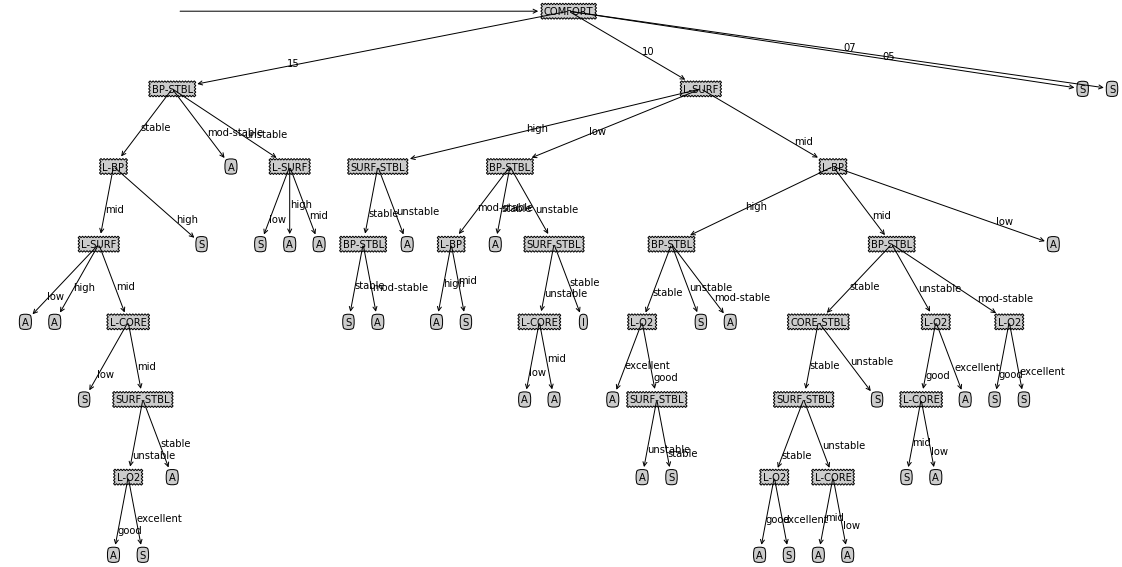

In [14]:
create_plot(tree)

In [15]:
"""
测试
"""
def classify(inputTree,featList,testVec):
    firstFeat = list(inputTree.keys())[0]
    currentTree = inputTree[firstFeat]
    value = testVec[featList.index(firstFeat)]
    deeperTree = currentTree[value]
    if isinstance(deeperTree,dict):    #非叶子结点则继续递归深入
        rtn = classify(deeperTree,featList,testVec)
    else:
        rtn = deeperTree               #叶子节点则返回叶子
    return rtn


In [17]:
testfilename = "C:/Users/charo/Desktop/post-operative-10-1tst.txt"
testSet = createDataSet(testfilename)
featList = ['L-CORE','L-SURF','L-O2','L-BP','SURF-STBL','CORE-STBL','BP-STBL','COMFORT']
hit = 0
for data in testSet:
    predict = classify(tree,featList,data)
    if data[-1] == predict:
            hit +=1
accuracy = hit/len(testSet)
print("Accuracy:"+str(accuracy))

Accuracy:0.6666666666666666


### 结果：测试结果 66.7%

# 连续值决策树
##### 数据集Glass Identification from KEEL-dataset -
##### https://sci2s.ugr.es/keel/dataset.php?cod=20
#### 数据集任务描述：9个连续特征值表示不同化学元素含量，对玻璃种类进行分类
***
***
 
    RI [1.51115, 1.53393]
    Na [10.73, 17.38]
    Mg [0.0, 4.49]
    Al [0.29, 3.5]
    Si [69.81, 75.41]
    K [0.0, 6.21]
    Ca [5.43, 16.19]
    Ba [0.0, 3.15]
    Fe [0.0, 0.51]
    
    output： {1，2，3，4，5，6，7}
***
***
### 测试集 23条 训练集191条

In [113]:
#根据阈值将连续值数据集划分
def splitSeriesDataSet(dataSet,i,th):
    smallerSet=[]
    biggerSet = []
    for data in dataSet:
        if float(data[i])<th:
            smallerSet.append(data)
        else:
            biggerSet.append(data)
    return smallerSet,biggerSet

#计算两类分化的香农熵
def calcEntOf2Classes(Set1,Set2):
    num = len(Set1)+len(Set2)
    Ent = len(Set1)/num*calcEnt(Set1)+len(Set2)/num*calcEnt(Set2)
    return Ent


#计算第i个特征最好的连续值划分点及其信息增益
def calcSeriesGain(dataSet,i):
    S = calcEnt(dataSet)
    maxGain = 0.0
    splitValue = -1
    valueList = [float(data[i]) for data in dataSet]#
    classList = [data[-1] for data in dataSet]
    dictList = dict(zip(valueList,classList))
    sortedValueList = sorted(dictList.items())
    
    midValueList = []
    for j in range(len(sortedValueList)-1):
        midValueList.append(round((sortedValueList[j][0] + 
                                   sortedValueList[j+1][0])/2.0, 3)) #计算相邻值的中值
   
    for mid in midValueList:
        smallerSet, biggerSet = splitSeriesDataSet(dataSet, i, mid)
        EntOfmid = calcEntOf2Classes(smallerSet,biggerSet)
        gain = S-EntOfmid
        if gain > maxGain:
            splitValue = mid
            maxGain = gain
    return maxGain,splitValue
   
    

In [136]:
def buildSeriesTree(dataSet,kidTree):
    i=0
    rtn = kidTree
    tempGain = []
    tempMid = []
    while i<len(dataSet[0])-1:
        currentGain,currentMid = calcSeriesGain(dataSet,i)
        tempGain.append(currentGain)
        tempMid.append(currentMid)
        i+=1
    attr = tempGain.index(max(tempGain))
    if(tempGain[attr]) == 0:                    #Gain为0建树完成，返回分类作为叶子
            rtn = dataSet[0][-1]
            return rtn
    featList = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe']
    
    feat = featList[attr]
    rtn[feat] = {}
    mid = tempMid[attr]
    smallerSet,biggerSet = splitSeriesDataSet(dataSet,attr,mid)
    rtn[feat]["<"+str(mid)] = buildSeriesTree(smallerSet,{})
    rtn[feat][">"+str(mid)] = buildSeriesTree(biggerSet,{})
    return rtn,tempMid
    
    
    
        

In [174]:
"""
@relation glass
@attribute RI real [1.51115, 1.53393]
@attribute Na real [10.73, 17.38]
@attribute Mg real [0.0, 4.49]
@attribute Al real [0.29, 3.5]
@attribute Si real [69.81, 75.41]
@attribute K real [0.0, 6.21]
@attribute Ca real [5.43, 16.19]
@attribute Ba real [0.0, 3.15]
@attribute Fe real [0.0, 0.51]
@attribute TypeGlass {1, 2, 3, 4, 5, 6, 7}
@inputs RI, Na, Mg, Al, Si, K, Ca, Ba, Fe
@outputs TypeGlass
@data
"""
filename1="C:/Users/charo/Desktop/glass-10-1tra.txt"
trainSeriesSet = createDataSet(filename1)
len(trainSeriesSet)


191

In [140]:
serialTree=buildSeriesTree(trainSeriesSet,{})

41.0


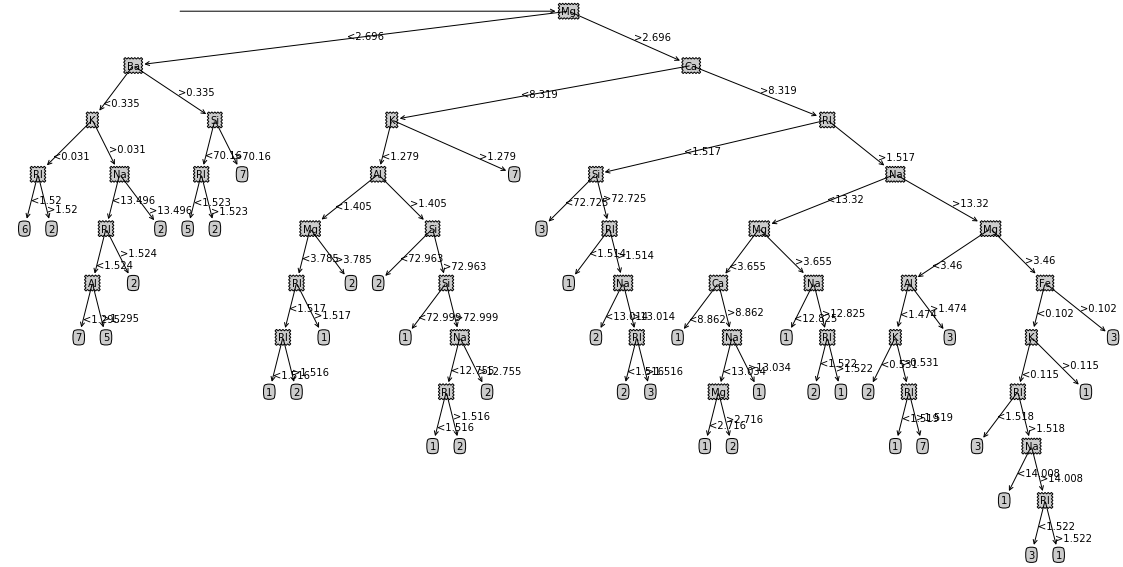

In [144]:
create_plot(serialTree)

In [164]:
"""
测试
"""
def classifySerial(inputTree,featList,testVec):
    firstFeat = list(inputTree.keys())[0]
    currentTree = inputTree[firstFeat]
    value = float(testVec[featList.index(firstFeat)])
    currentMid = float(list(currentTree.keys())[0].strip("<"))
  
    if(value<currentMid):
        deeperTree = currentTree[list(currentTree.keys())[0]]
    else:
         deeperTree = currentTree[list(currentTree.keys())[1]]
    if isinstance(deeperTree,dict):    #非叶子结点则继续递归深入
        rtn = classifySerial(deeperTree,featList,testVec)
    else:
        rtn = deeperTree               #叶子节点则返回叶子
    return rtn


In [165]:
featList = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe']
filename2 ="C:/Users/charo/Desktop/glass-10-1tst.txt"
testSeriesSet = createDataSet(filename2)
hit = 0
for data in testSeriesSet:
    predict = classifySerial(serialTree,featList,data)
    if data[-1] == predict:
            hit +=1
accuracy = hit/len(testSeriesSet)
print("Accuracy:"+str(accuracy))

Accuracy:0.6521739130434783


### 结果： 准确度 65.2%